# Pre-requisites  
- download dataset.zip,  
- unzip dataset,    
- mount drive,  

In [1]:
# Package installations
from IPython.utils import io
with io.capture_output() as captured:
    !pip install gdown
    !pip3 install pillow==8.2.0
    !pip install neptune-client
    !pip install neptune-client neptune-tensorboard
    !pip install neptune-contrib
    !pip install imgaug==0.2.6

In [2]:
!pip install cython
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-xu0fr585
  Running command git clone -q https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-xu0fr585
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 0d53acbcf5123d4c88040fe68fbb9805fc5b2fb9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [4]:
# %cd /content/
# Download VOC2012
# !gdown https://drive.google.com/uc?id=1PDTEuTnWJZNWogxYdqYGOlEZHK8dYET9

# Download custom Kvasir-v2
# ! gdown https://drive.google.com/uc?id=1WG5F7VVQe6mNupR1LLirkG_Apx6Bup5J

/content


In [5]:
# with io.capture_output() as captured:
#   # !unzip -q VOC2012.zip
#   !unzip -q Kvasir-v2.zip
#   # !rm -rf VOC2012.zip
#   !rm -rf Kvasir-v2.zip

In [6]:
# from IPython.utils import io
# with io.capture_output() as captured:
#   from google.colab import drive 
#   drive.mount('/content/drive')
# %cd /content/drive/MyDrive/MAI/thesis/source

/content/drive/MyDrive/MAI/thesis/source


In [7]:
# %cd /content/drive/MyDrive/MAI/thesis/source

/content/drive/MyDrive/MAI/thesis/source


# Imports

In [3]:
import numpy as np
import sys
sys.path.append('/home/charis/kul-thesis/OAA')
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
import PIL.Image
import os.path
import scipy.misc
from utils import imutils
from torchvision import transforms
import cv2
import pandas as pd
import random, tqdm
import albumentations as album

IMG_FOLDER_NAME = "polyps/"
ANNOT_FOLDER_NAME = "polyps/masks"

CAT_LIST = ['dyed-lifted-polyp',
            'dyed-resection-margins',
            'esophagitis',
            'normal-cecum',
            'normal-pylorus',
            'normal-z-line', 
            'polyps',
            'ulcerative-colitis']

CAT_NAME_TO_NUM = dict(zip(CAT_LIST,range(len(CAT_LIST))))


def load_image_label_list_from_npy(img_name_list):
    cls_labels_dict = np.load('kvasirv2/cls_labels.npy', allow_pickle=True).item()
    # print(cls_labels_dict)
    return [cls_labels_dict[img_name] for img_name in img_name_list]

def get_img_path(img_name, dataset_root):
    return os.path.join(dataset_root, img_name)

def load_img_name_list(dataset_path):
    img_gt_name_list = open(dataset_path).read().splitlines()
    img_name_list = [img_gt_name.split(' ')[0][-40:-4] for img_gt_name in img_gt_name_list]
    folder_paths_list = [img_gt_name.split(' ')[0] for img_gt_name in img_gt_name_list]
    return img_name_list, folder_paths_list

def load_label_list(dataset_path):
    zero_array = np.zeros(8, dtype=np.float32)
    list_of_arrays = []
    for i in range(8):
        z = np.zeros(8, dtype=np.float32)
        z[i]=1.0
        list_of_arrays.append(z)
    #print(list_of_arrays)
    img_name_list = open(dataset_path).read().splitlines()
    label_list = [list_of_arrays[int(img_name[-1:])-1] for img_name in img_name_list]
    return label_list

class KvasirImageDataset(Dataset):
    def __init__(self, img_name_list_path, dataset_root, transform=None):
        self.img_name_list, self.folder_paths_list = load_img_name_list(img_name_list_path)
        self.dataset_root = dataset_root
        self.transform = transform

    def __len__(self):
        return len(self.img_name_list)

    def __getitem__(self, idx):
        name = self.img_name_list[idx]
        path = self.folder_paths_list[idx]
        # print(get_img_path(path, self.dataset_root))
        img = PIL.Image.open(get_img_path(path, self.dataset_root)).convert("RGB")
        # img = torch.from_numpy(np.array(img))

        if self.transform:
            img = self.transform(img)

        return name, img


class KvasirClsDataset(KvasirImageDataset):           # inherit init from previous class
    def __init__(self, img_name_list_path, dataset_root, transform=None):
        super().__init__(img_name_list_path, dataset_root, transform)
        self.label_list = load_image_label_list_from_npy(self.img_name_list)        # get list from .npy file
        #self.label_list = load_image_label_list_from_xml(self.img_name_list, self.dataset_root)

    def __getitem__(self, idx):
        name, img = super().__getitem__(idx)

        label = torch.from_numpy(self.label_list[idx])

        return name, img, label

class KvasirClsDatasetMSF(KvasirClsDataset):
    def __init__(self, img_name_list_path, data_root, scales, inter_transform=None, unit=1):
        super().__init__(img_name_list_path, data_root, transform=None)
        self.scales = scales
        self.unit = unit
        self.inter_transform = inter_transform

    def __getitem__(self, idx):
        name, img, label = super().__getitem__(idx)

        rounded_size = (int(round(img.size[0]/self.unit)*self.unit), int(round(img.size[1]/self.unit)*self.unit))

        ms_img_list = []
        for s in self.scales:
            target_size = (round(rounded_size[0]*s),
                           round(rounded_size[1]*s))
            s_img = img.resize(target_size, resample=PIL.Image.CUBIC)
            ms_img_list.append(s_img)

        if self.inter_transform:
            for i in range(len(ms_img_list)):
                ms_img_list[i] = self.inter_transform(ms_img_list[i])

        msf_img_list = []
        for i in range(len(ms_img_list)):
            msf_img_list.append(ms_img_list[i])
            msf_img_list.append(np.flip(ms_img_list[i], -1).copy())

        return name, msf_img_list, label

class KvasirClsDatasetMS(KvasirClsDataset):
    def __init__(self, img_name_list_path, dataset_root, scales, inter_transform=None, unit=1):
        super().__init__(img_name_list_path, dataset_root, transform=None)
        self.scales = scales
        self.unit = unit
        self.inter_transform = inter_transform

    def __getitem__(self, idx):
        name, img, label = super().__getitem__(idx)

        rounded_size = (int(round(img.size[0]/self.unit)*self.unit), int(round(img.size[1]/self.unit)*self.unit))

        ms_img_list = []
        for s in self.scales:
            target_size = (round(rounded_size[0]*s),
                           round(rounded_size[1]*s))
            s_img = img.resize(target_size, resample=PIL.Image.CUBIC)
            ms_img_list.append(s_img)

        if self.inter_transform:
            for i in range(len(ms_img_list)):
                ms_img_list[i] = self.inter_transform(ms_img_list[i])

        return name, ms_img_list, label

# Kvasir dataloaders


In [4]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [5]:
def get_data_loader(data_dir, batch_size=32, train=True):
    # define how we augment the data for composing the batch-dataset in train and test step
    transform = {
        'train': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.Resize(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(90),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
    }

    # ImageFolder with root directory and defined transformation methods for batch as well as data augmentation
    if train:
      data = ImageFolderWithPaths(root=data_dir, transform=transform['train'])
    else:
      data = ImageFolderWithPaths(root=data_dir, transform=transform['test'])
    data_loader = torch.utils.data.DataLoader(dataset=data, batch_size=batch_size, shuffle=True, num_workers=2)

    return data.class_to_idx, data_loader 

In [6]:
torch.multiprocessing.freeze_support()

test_dir = '/home/charis/kul-thesis/kvasir-dataset-v2-folds/1/test'
infer_dir = '/home/charis/kul-thesis/kvasir-dataset-v2-folds/1/train'

# mapp, test_data_loader = get_data_loader(data_dir=test_dir, batch_size=32, train=False)
# mapp, test_data_loader2 = get_data_loader(data_dir=test_dir2, batch_size=32, train=False)
mapp, infer_data_loader = get_data_loader(data_dir=infer_dir, batch_size=16, train=False)

In [7]:
import pathlib
# test_data_dir = pathlib.Path(test_dir)
# test_data_dir2 = pathlib.Path(test_dir2)
infer_data_dir = pathlib.Path(infer_dir)

In [8]:
total_infer = len(list(infer_data_dir.glob('*/*.jpg')))
total_infer

7200

In [14]:
# total_test = len(list(test_data_dir.glob('*/*.jpg')))
# total_test2 = len(list(test_data_dir2.glob('*/*.jpg')))
# total_test, total_test2

In [9]:
#get the class names
# CLASS_NAMES = np.array([item.name for item in test_data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES = list(mapp.keys())
CLASS_NAMES

['dyed-lifted-polyps',
 'dyed-resection-margins',
 'esophagitis',
 'normal-cecum',
 'normal-pylorus',
 'normal-z-line',
 'polyps',
 'ulcerative-colitis']

In [10]:
# Check first batch
iter(infer_data_loader).next()[0].shape

torch.Size([16, 3, 224, 224])

# Alternative dataloaders

In [11]:
CLASS_NAMES = [ 'dyed-lifted-polyps',
                'dyed-resection-margins',
                'esophagitis',
                'normal-cecum',
                'normal-pylorus',
                'normal-z-line',
                'polyps',
                'ulcerative-colitis']

class KvasirDataset(Dataset):
    """Reads all images in root dir without .txt file"""
    def __init__(self, root_dir, num_classes=8, transform=None, test=False):
        self.root_dir = root_dir
        self.testing = test
        self.transform = transform
        self.num_classes = num_classes
        self.image_list, self.label_list = self.read_labeled_image_list()

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name =  self.image_list[idx]
        image = Image.open(img_name).convert('RGB')
        
        if self.transform is not None:
            image = self.transform(image)
        if self.testing:
            return img_name, image, self.label_list[idx]
        
        return image, self.label_list[idx]

    def read_labeled_image_list(self, data_dir):
        data_dir = self.root_dir
 
        img_name_list = []
        img_labels = []
        for line in lines:
            fields = line.strip().split()
            image = fields[0] + '.jpg'
            labels = np.zeros((self.num_classes,), dtype=np.float32)
            for i in range(len(fields)-1):
                index = int(fields[i+1])
                labels[index] = 1.
            img_name_list.append(os.path.join(data_dir, image))
            img_labels.append(labels)
        return img_name_list, img_labels#, np.array(img_labels, dtype=np.float32)

# OAA infer
Imports

Change directory to OAA-PyTorch




In [18]:
# %cd OAA/

/content/drive/My Drive/MAI/thesis/source/OAA


In [12]:
import imageio
import sys
# sys.path.append('/content/drive/MyDrive/MAI/thesis/source/OAA')

import os
import cv2
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import argparse
import torchvision
from torchvision import models, transforms
from torch.utils.data import DataLoader
# from utils.LoadData import test_data_loader
from utils.Restore import restore
import matplotlib.pyplot as plt
from models import vgg
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import utils.imutils as imutils
import kvasirv2.data

colormaps = ['#000000', '#996633', '#ff9900', '#cc0066', '#660066', '#3333cc', '#00ffff', '#33cc33', '#ffff00']

# Parameters

In [26]:
# For Kvasir v2
data_root = '/content/drive/MyDrive/MAI/thesis/source/kvasir-dataset-v2' 
save_dir = './results_kvasir/exp8/attention/'
img_dir = '/content/drive/MyDrive/MAI/thesis/source/kvasir-dataset-v2'

batch_size = 32
input_size = 224
dataset = 'kvasir'
num_classes = 8
num_workers = 2

restore_from = '/home/charis/kul-thesis/OAA/checkpoints/train/exp9/kvasirv2_epoch_15.pth'
out_cam = './results_kvasir/exp10/results_cam/'
out_crf = './results_kvasir/exp10/results_crf/'
out_cam_pred_alpha = 0.26
crop_size = 224
out_cam_pred = "./results_kvasir/exp10/results_cam_pred/"

In [21]:
sys.path.append('/content/drive/MyDrive/MAI/thesis/source/OAA/utils/transforms')
sys.path.append('/content/drive/MyDrive/MAI/thesis/source/OAA/utils/')

In [27]:
import utils.transforms.transforms as transforms
from torch.utils.data import DataLoader
import torchvision
import torch
import numpy as np
from torch.utils.data import Dataset
from utils.imutils import RandomResizeLong
import os
from PIL import Image
import random

# vgg.py


In [28]:
import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo        # Loads the Torch serialized object at the given URL
import torch.nn.functional as F
import math
import cv2
import numpy as np
import os

model_urls = {'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth'}      # dict with standard VGG from online directory

class VGG(nn.Module):
    def __init__(self, features, num_classes=1000, init_weights=True, att_dir='./results_voc/', training_epoch=15):
        super(VGG, self).__init__()
        self.features = features
        self.nclasses = num_classes
        self.extra_convs = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(512,num_classes,1)                    # include 4 new conv layers, last one has 8 outputs for the 8 classes
        )
        self._initialize_weights()
        self.training_epoch = training_epoch
        self.att_dir = att_dir
        if not os.path.exists(self.att_dir):
            os.makedirs(self.att_dir)

    def forward(self, x, epoch=1, label=None, index=None):
        x = self.features(x)
        x = self.extra_convs(x)
        self.map1 = x.clone()
        x = F.avg_pool2d(x, kernel_size=(x.size(2), x.size(3)), padding=0)
        x = x.view(-1, self.nclasses)
        
        ###  the online attention accumulation process
        pre_probs = x.clone()
        probs = torch.sigmoid(pre_probs)  # compute the prob
        
        if index != None and epoch > 0:
            atts = self.map1
            atts[atts < 0] = 0
            ind = torch.nonzero(label)

            for i in range(ind.shape[0]):
                batch_index, la = ind[i]
                accu_map_name = '{}{}_{}.png'.format(self.att_dir, batch_index+index, la)
                att = atts[batch_index, la].cpu().data.numpy()
                att = att / (att.max() + 1e-8) * 255
                
                # if this is the last epoch and the image without any accumulation
                if epoch == self.training_epoch - 1 and not os.path.exists(accu_map_name):
                    cv2.imwrite(accu_map_name, att)
                    continue
                
                # naively filter out the low quality attention map with prob
                if probs[batch_index, la] < 0.1:  
                    continue
                # print(f'accu_map_name:{accu_map_name}')
                if att is not None:
                    if not os.path.exists(accu_map_name):
                        cv2.imwrite(accu_map_name, att)
                else:
                    accu_att = cv2.imread(accu_map_name, 0)
                    if att is not None:
                        if accu_att is not None:
                            accu_att = np.maximum(accu_att, att)
                            cv2.imwrite(accu_map_name,  accu_att)
         ##############################################

        return x

    def get_heatmaps(self):
        return self.map1

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
    
    def get_parameter_groups(self):
        groups = ([], [], [], [])

        for name, value in self.named_parameters():

            if 'extra' in name:
                if 'weight' in name:
                    groups[2].append(value)
                else:
                    groups[3].append(value)
            else:
                if 'weight' in name:
                    groups[0].append(value)
                else:
                    groups[1].append(value)
        return groups


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for i, v in enumerate(cfg):
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'N':
            layers += [nn.MaxPool2d(kernel_size=3, stride=1, padding=1)]
        else:
            if i > 13:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, dilation=2, padding=2)            
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'D1': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'N', 512, 512, 512],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


def vgg16(pretrained=False, **kwargs):        # input arg: num classes
    model = VGG(make_layers(cfg['D1']), **kwargs)  
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg16']), strict=False)      # get pretrained VGG from URL
    return model

# functions

In [29]:
def colormap(index):
    return mpl.colors.LinearSegmentedColormap.from_list('cmap', [colormaps[0], colormaps[index+1], '#FFFFFF'], 256)

def _crf_with_alpha(orig_img, cam_dict, alpha):
    v = np.array(list(cam_dict.values()))       # change dict to array
    bg_score = np.power(1 - np.max(v, axis=0, keepdims=True), alpha)
    bgcam_score = np.concatenate((bg_score, v), axis=0)
    crf_score = imutils.crf_inference(np.ascontiguousarray(orig_img.astype(np.uint8)), bgcam_score, labels=bgcam_score.shape[0])

    n_crf_al = dict()

    n_crf_al[0] = crf_score[0]
    for i, key in enumerate(cam_dict.keys()):
        n_crf_al[key+1] = crf_score[i+1]

    return n_crf_al

def get_model():
    model = vgg16(num_classes=num_classes)
    # model = torch.nn.DataParallel(model).cuda()
    pretrained_dict = torch.load(restore_from, map_location=torch.device('cpu'))['state_dict']
    model_dict = model.state_dict()
    
    # print(model_dict.keys())
    # print(pretrained_dict.keys())
    
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict.keys()}
    # print("Weights cannot be loaded:")
    print([k for k in model_dict.keys() if k not in pretrained_dict.keys()])

    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    # print(model)

    return  model

def worker_init_fn(worker_id):
      np.random.seed(1 + worker_id)

In [30]:
model = get_model()

['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'extra_convs.0.weight', 'extra_convs.0.bias', 'extra_convs.2.weight', 'extra_convs.2.bias']


In [31]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

# Plot CM (train and val)

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [33]:
preds_total = torch.tensor([])
labels_total = torch.tensor([])
with torch.no_grad():
  for idx, dat in tqdm(enumerate(infer_data_loader,0)):
            imgs, lbls, fname = dat
            imgs = imgs.to('cpu')         # to cpu
            lbls = lbls.to('cpu')         # same
            outputs = model(imgs)         # get model output
            _, predicted = torch.max(outputs.data, 1)

            preds_total = torch.cat(
              (preds_total, predicted)
              ,dim=0)
            labels_total = torch.cat(
              (labels_total, lbls)
              ,dim=0)

cm_val = confusion_matrix(preds_total.view(-1), labels_total.view(-1))

450it [14:24,  1.92s/it]


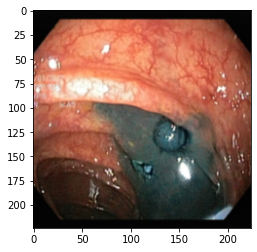

In [34]:
imshow(dat[0][3])

Text(33.0, 0.5, 'Predicted classes')

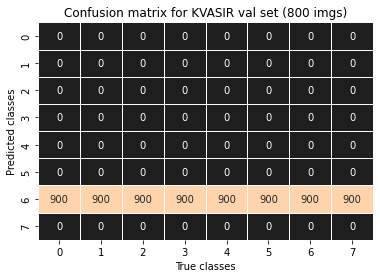

In [35]:
import seaborn as sns
ax = plt.axes()
sns.heatmap(cm_val, annot=True, fmt='d', cbar=False, linewidth=1, center=0)
ax.set_title('Confusion matrix for KVASIR val set (800 imgs)')
ax.set_xlabel('True classes')
ax.set_ylabel('Predicted classes')


In [36]:
preds_total = torch.tensor([])
labels_total = torch.tensor([])
with torch.no_grad():
  for idx, dat in enumerate(test_data_loader2,0):
            imgs, lbls, fname = dat
            imgs = imgs.to('cpu')         # to cpu
            lbls = lbls.to('cpu')         # same
            outputs = model(imgs)         # get model output
            _, predicted = torch.max(outputs.data, 1)

            preds_total = torch.cat(
              (preds_total, predicted)
              ,dim=0)
            labels_total = torch.cat(
              (labels_total, lbls)
              ,dim=0)

cm_train = confusion_matrix(preds_total.view(-1), labels_total.view(-1))

NameError: name 'test_data_loader2' is not defined

In [ ]:
import seaborn as sns
ax = plt.axes()
sns.heatmap(cm_train, annot=True, fmt='d', cbar=False, linewidth=1, center=0)
ax.set_title('Confusion matrix for KVASIR training set (7200 imgs)')
ax.set_xlabel('True classes')
ax.set_ylabel('Predicted classes')

# Inference step

In [ ]:
globl_counter = 0
crf_alpha = [4,24]
for idx, dat in enumerate(infer_data_loader,0):
          imgs, lbls, fname = dat
          imgs = imgs.to('cpu')         # to cpu
          lbls = lbls.to('cpu')         # same
          outputs = model(imgs)         # get model output
          _, predicted = torch.max(outputs.data, 1)     # predict label

          last_featmaps = model.get_heatmaps()          # get featmap
          for im in range(batch_size):                  # for all images in batch calculate attention
            fname_new = fname[im].split('/')
            im_name = os.path.join(save_dir, fname_new[-1][0:-4] + '.npy')
            # if os.path.exists(im_name):
            #   # print(fname_new[-1][0:-4], ' exists')
            #   continue
            # orig_img = np.asarray(Image.open(fname[im]))
            orig_img = imgs[im].numpy()
            orig_img = np.transpose(orig_img, (1, 2, 0))
            
            height, width = orig_img.shape[0], orig_img.shape[1]

            orig = np.asarray(Image.open(fname[im]))
            orig_img = cv2.resize(orig, (width, height), interpolation = cv2.INTER_CUBIC)

            # print(height, width)

            cam_dict = {}
            maps = last_featmaps[im].cpu().data.numpy()        # get heatmap of label (single label)
            cv_im_gray = cv2.cvtColor(orig_img, cv2.COLOR_BGR2GRAY)       # make it gray

            labels = lbls.cpu().long().numpy()                            # get label
            
            att = maps[predicted[im]]                                     # get the heatmap and start processing
            att[att < 0] = 0
            att = att / (np.max(att) + 1e-5)
            cam_max = np.max(att)
            cam_min = np.min(att)

            norm_cam = cv2.resize(att, (width, height), interpolation = cv2.INTER_CUBIC)      # normalize to 0 to 1 
            norm_cam = (norm_cam-cam_min-1e-5) / (cam_max  - cam_min + 1e-5)
            cam_dict[predicted[im]] = norm_cam                                                # build dictionary
            att = np.array(att * 255, dtype=np.uint8)                                         # make to image

            globl_counter += 1

            out_name = im_name[0:-4] + '_{}.png'.format(predicted[im])                              # just save the image (name is random)
            att = cv2.resize(att, (width, height), interpolation=cv2.INTER_CUBIC)
            att = cv_im_gray*0.7 + att*0.3
            # att = (att-att.min()) / (att.max()  - att.min())
            # att = np.array(att * 255, dtype=np.uint8)

            if not os.path.exists(save_dir):
                    os.makedirs(save_dir)

            plt.imsave(out_name, att)#, cmap='seismic')#cmap=colormap(labels[im])) 

            if out_cam is not None:
                if not os.path.exists(out_cam):
                    os.makedirs(out_cam)
                np.save(os.path.join(out_cam, fname_new[-1][0:-4] + '.npy'), cam_dict)        # save dictionary at ./results_cam

            if out_crf is not None:
                if not os.path.exists(out_crf):
                    os.makedirs(out_crf)
                for t in crf_alpha:
                    crf = _crf_with_alpha(orig_img, cam_dict, t)
                    folder = out_crf + ('_%.1f'%t)
                    if not os.path.exists(folder):
                        os.makedirs(folder)
                    np.save(os.path.join(folder, fname_new[-1][0:-4] + '.npy'), crf)


In [ ]:
fname = test_data_loader.dataset.samples[1][0].split('/')
fname[-1][0:-4]

'kvasir_v2__fold_1_test_class_dyed-lifted-polyps_frame_1'

./results_kvasir/exp8/attention/0301983f-0196-45ff-b376-0faa61d551e6_4.png


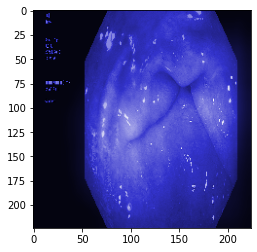

In [ ]:
print(out_name)
plt.imshow(att, cmap=colormap(labels[im]))

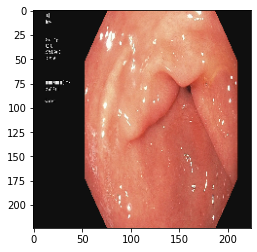

In [ ]:
plt.imshow(orig_img)

In [ ]:
def validate():
  criterion =  torch.nn.CrossEntropyLoss()
  model = get_model()
  model.eval()
  crf_alpha = [4,24]
  if not os.path.exists(save_dir):
      os.mkdir(save_dir)

  corrects = 0
  total_sum = 0
  with torch.no_grad():
      for imgs, lbls in test_data_loader:
          imgs = imgs.cuda()
          lbls = lbls.cuda()

          outputs = model(imgs)
          last_featmaps = model.get_heatmaps()
          for i in range(batch_size):
            orig_img = imgs[i].numpy()
            orig_img = np.transpose(orig_img, (1, 2, 0))
            orig_img_size = orig_img.shape[:2]
          
          loss = criterion(outputs, lbls)

          _, predicted = torch.max(outputs.data, 1)
          total_sum += lbls.size(0)
          corrects += (predicted == lbls).sum().item()

  print('Acc val set: %f %%' % (
      100 * corrects / total_sum))
  print('Val loss: ', float(loss.cpu().numpy()))
  neptune.log_metric('loss', loss.cpu().numpy())
  return loss.data

In [ ]:
# def validate():
#   print('\nvalidating ... ', flush=True, end='')
#   crf_alpha = [4,24]
#   model = get_model()
#   model.eval()


#   if not os.path.exists(save_dir):
#       os.mkdir(save_dir)

#   with torch.no_grad():
#       for idx, dat in enumerate(test_data_loader):
#           img_name, img, label_in = dat
          
#           label = label_in.cuda(non_blocking=True)
#           logits = model(img)
#           last_featmaps = model.module.get_heatmaps()
#           # last_featmaps = model.get_heatmaps()
          

#           for img_el in img_name:
#             img_name_path = img_el.split('/')[-1][:-4]
#             if os.path.exists(os.path.join(out_cam, img_name_path + '.npy')):
#               continue

#             orig_img = np.asarray(Image.open(img_el))                         # load 1st img
#             orig_img_size = orig_img.shape[:2]
#             height, width = orig_img_size[0], orig_img_size[1]
#             ii = 0

#             for l, featmap in enumerate(last_featmaps):
#                 cam_dict = {}
#                 maps = featmap.cpu().data.numpy()
#                 orig_img = img[ii].permute(1, 2, 0).numpy()
#                 ii = ii + 1
#                 cv_im_gray = cv2.cvtColor(orig_img.astype(np.uint8), cv2.COLOR_BGR2GRAY)
#                 cv_im_gray = cv2.resize(cv_im_gray, (width, height), interpolation = cv2.INTER_CUBIC)

#                 img_name_path = img_el.split('/')[-1][:-4]
#                 # print(img_name_path)
#                 im_name = save_dir + img_el.split('/')[-1][:-4]

#                 labels = label.cpu().long().numpy()[l]
#                 for i in range(int(num_classes)):
#                     if labels[i] == 1:
#                         # print(i, labels)
#                         att = maps[i]
#                         att[att < 0] = 0
#                         att = att / (np.max(att) + 1e-5)
#                         cam_max = np.max(att)
#                         cam_min = np.min(att)
#                         # print('max and min of cam: ',cam_max)#, np.shape(cam_min))

#                         norm_cam = cv2.resize(att, (width, height), interpolation = cv2.INTER_CUBIC)
#                         norm_cam = (norm_cam-cam_min-1e-5) / (cam_max - cam_min + 1e-5)
#                         cam_dict[i] = norm_cam
#                         att = np.array(att * 255, dtype=np.uint8)
#                         out_name = im_name + '_{}.png'.format(i)
#                         # att = cv2.resize(att, (width, height), interpolation=cv2.INTER_CUBIC)
#                         # att = cv_im_gray * 0.2 + att * 0.8
#                         # plt.imsave(out_name, att, cmap=colormap(i))
#                 if out_cam is not None:
#                     if not os.path.exists(out_cam):
#                         os.makedirs(out_cam)
#                     np.save(os.path.join(out_cam, img_name_path + '.npy'), cam_dict)        # save dictionary at ./results_cam
#                     #print(os.path.join(.out_cam, img_name_path + '.npy'))

#                 # if out_cam_pred is not None:
#                 #     if not os.path.exists(out_cam_pred):
#                 #         os.makedirs(out_cam_pred)
#                 #     bg_score = [np.ones_like(norm_cam)*out_cam_pred_alpha]          # make bg image with ones at correct dimensions
#                 #     pred = np.argmax(np.concatenate((bg_score, norm_cam)), 0)
#                 #     # print(out_cam_pred + img_name_path + '.png')
#                 #     plt.imsave(out_cam_pred + img_name_path + '.png', pred.astype(np.uint8))
#                 orig_img = np.asarray(Image.open(img_el))

#                 if out_crf is not None:
#                     if not os.path.exists(out_crf):
#                         os.makedirs(out_crf)
#                     for t in crf_alpha:
#                         crf = _crf_with_alpha(orig_img, cam_dict, t)
#                         folder = out_crf + ('_%.1f'%t)
#                         if not os.path.exists(folder):
#                             os.makedirs(folder)
#                         np.save(os.path.join(folder, img_name_path + '.npy'), crf)



In [ ]:
validate()

In [ ]:
print('\nvalidating ... ', flush=True, end='')
crf_alpha = [4,24]
model = get_model()
model.eval()
mean_vals = [0.485, 0.485, 0.485]              # for standardization
std_vals = [0.335, 0.335, 0.335]

# val_loader = test_data_loader()
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

with torch.no_grad():
    for idx, dat in tqdm(enumerate(val_loader)):   
        img_name, img, label_in = dat       
        label = label_in.cuda(non_blocking=True)
        logits = model(img)
        last_featmaps = model.module.get_heatmaps()
        img_el = img_name[0]
        break

In [ ]:
last_featmaps.shape

In [ ]:
img_el

In [ ]:
orig_img = np.asarray(Image.open(img_el))                         # load img
orig_img_size = orig_img.shape[:2]
height, width = orig_img_size[0], orig_img_size[1]
ii = 0

for l, featmap in enumerate(last_featmaps):
    cam_dict = {}
    maps = featmap.cpu().data.numpy()
    orig_img = img[ii].permute(1, 2, 0).numpy()
    ii = ii + 1
    cv_im_gray = cv2.cvtColor(orig_img.astype(np.uint8), cv2.COLOR_BGR2GRAY)
    cv_im_gray = cv2.resize(cv_im_gray, (width, height), interpolation = cv2.INTER_CUBIC)

    # print(maps)
    img_name_path = img_el.split('/')[-1][:-4]
    im_name = save_dir + img_el.split('/')[-1][:-4]
    # print(img_name_path)
    labels = label_in.long().numpy()[l]
    for i in range(int(num_classes)):
        if labels[i] == 1:
            att = maps[i]
            # plt.figure()
            # plt.imshow(att)
            # plt.title('maps')

            att = cv2.resize(att, (width, height), interpolation=cv2.INTER_CUBIC)
            att = att / (np.max(att) + 1e-8)
            cam_max = np.max(att) # find min and max
            cam_min = np.min(att)

            norm_cam = cv2.resize(att, (width, height), interpolation = cv2.INTER_CUBIC)
            norm_cam = (norm_cam-cam_min-1e-5) / (cam_max - cam_min + 1e-5)

            plt.figure()
            plt.imshow(norm_cam)
            plt.title('norm_cam')

            cam_dict[i] = norm_cam
            att = np.array(norm_cam * 255, dtype=np.uint8)
            # att = cv2.resize(att, (width, height), interpolation=cv2.INTER_CUBIC)
            att = cv_im_gray * 0.2 + att * 0.8
            plt.figure()
            plt.imshow(att, cmap=colormap(i))
            plt.title('final')

    orig_img = np.asarray(Image.open(img_el))

    def _crf_with_alpha(cam_dict, alpha):
            v = np.array(list(cam_dict.values()))       # change dict to array
            bg_score = np.power(1 - np.max(v, axis=0, keepdims=True), alpha)
            bgcam_score = np.concatenate((bg_score, v), axis=0)
            crf_score = imutils.crf_inference(orig_img, bgcam_score, labels=bgcam_score.shape[0])

            n_crf_al = dict()
            n_crf_al[0] = crf_score[0]
            for i, key in enumerate(cam_dict.keys()):
                n_crf_al[key+1] = crf_score[i+1]

            return n_crf_al

    # if out_cam_pred is not None:
    #         if not os.path.exists(out_cam_pred):
    #             os.makedirs(out_cam_pred)
    #         bg_score = [np.ones_like(norm_cam)*out_cam_pred_alpha]          # make bg image with ones at correct dimensions
    #         pred = np.argmax(np.concatenate((bg_score, norm_cam)), 0)
    #         plt.imsave(out_cam_pred + img_name_path + '.png', pred.astype(np.uint8))

    if out_crf is not None:
            crf = _crf_with_alpha(cam_dict, crf_alpha[0])
            crf2 = _crf_with_alpha(cam_dict, crf_alpha[1])

            # np.save(os.path.join(folder, img_name_path + '.npy'), crf)
    break

In [ ]:
label_in.long().numpy()[0]

In [ ]:
bg_score = [np.ones_like(norm_cam)*out_cam_pred_alpha]

In [ ]:
bg_score[0].shape

In [ ]:
plt.imshow(norm_cam)
plt.figure()
plt.imshow(orig_img)
plt.figure()
plt.imshow(att)

In [ ]:
label_la = crf
label_ha = crf2

In [ ]:
crf.keys()

In [ ]:
print(label_la[0].shape)     # image shape with bg
print(label_la[0].max())     # 1 and almost 0
print(label_la[0].min())     # 1 and almost 0

for i in label_la.keys():
  plt.figure()
  plt.imshow(label_la[i])
  plt.title(f'la w/ {i}')

In [ ]:
print(label_ha[0].shape)     # image shape with bg
print(label_ha[0].max())     # 1 and almost 0
print(label_ha[0].min())     # 1 and almost 0

for i in label_ha.keys():
  plt.figure()
  plt.imshow(label_ha[i])
  plt.title(f'ha w/ {i}')

In [ ]:
alpha = 4.0
v = np.array(list(cam_dict.values()))       # change dict to array
bg_score = np.power(1 - np.max(v, axis=0, keepdims=True), alpha)
bgcam_score = np.concatenate((bg_score, v), axis=0)
crf_score = imutils.crf_inference(orig_img, bgcam_score, labels=bgcam_score.shape[0])

In [ ]:
bg_score.max(), bg_score.min(), bg_score.shape

In [ ]:
bgcam_score.shape, bgcam_score.min(), bgcam_score.max()

# run .py script

In [ ]:
# !python ./scripts/infer.py \
#     --img_dir=/content/drive/MyDrive/MAI/thesis/source/kvasir-dataset-v2 \
#     --infer_list=./kvasirv2/val.txt \
#     --batch_size=32 \
#     --dataset=kvasir \
#     --input_size=256 \
# 	  --num_classes=8 \
#     --restore_from=./checkpoints/train/exp4/kvasir_epoch_13.pth \
#     --save_dir=./results_kvasir/exp4/attention/ \
#     --out_cam=./results_kvasir/exp4/results_cam \
#     --out_crf=./results_kvasir/exp4/results_crf \